In [3]:
!git clone https://github.com/EeshaanJain/Fairness

Cloning into 'Fairness'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 66 (delta 8), reused 66 (delta 8), pack-reused 0
Unpacking objects: 100% (66/66), 2.12 MiB | 9.09 MiB/s, done.


In [9]:
mv Fairness/* .

In [100]:
import numpy as np
import utils
import torch
import pandas as pd

from tqdm.auto import tqdm

from blackbox_models import BlackBox
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [102]:
device

device(type='cuda', index=0)

In [103]:
dfx, dfy, cols = utils.get_dataset('adult_income', return_dataframe=True)

In [104]:
from sklearn.preprocessing import minmax_scale

In [105]:
minmax_separate = False

In [106]:
def compute_disparity(x1, x2, use_blackbox=True):
    if use_blackbox:
        return torch.abs(blackbox(x1.float()).mean() - blackbox(x2.float()).mean())
    else:
        return torch.abs(x1.float().mean() - x2.float().mean())

In [107]:
blackbox = BlackBox('Logistic', 102, 1)
blackbox.load_state_dict(torch.load("checkpoints/adult_income/blackbox/Logistic/best.pt", map_location='cpu'))
blackbox.eval()
blackbox.to(device);

In [108]:
if minmax_separate:
    dfx_1 = dfx.loc[dfx.gender == 1]
    dfx_0 = dfx.loc[dfx.gender == 0]
    dfx_1[cols] = minmax_scale(dfx_1[cols])
    dfx_0[cols] = minmax_scale(dfx_0[cols])
else:
    dfx[cols] = minmax_scale(dfx[cols])
    dfx_1 = dfx.loc[dfx.gender == 1]
    dfx_0 = dfx.loc[dfx.gender == 0]
    dfy_1 = dfy.loc[dfx.gender == 1]
    dfy_0 = dfy.loc[dfx.gender == 0]

In [167]:
tensor_data_x0 = torch.tensor(dfx_0.values).to(device)
tensor_data_y0 = torch.tensor(dfy_0.values).to(device)
tensor_data_x1 = torch.tensor(dfx_1.values).to(device)
tensor_data_y1 = torch.tensor(dfy_1.values).to(device)

In [168]:
actual = compute_disparity(tensor_data_x0, tensor_data_x1)

In [111]:
INITIAL = 500

In [112]:
warm_start_samples_0 = utils.sample_from_tensor(tensor_data_x0.shape[0], INITIAL, device).long()
warm_start_samples_1 = utils.sample_from_tensor(tensor_data_x1.shape[0], INITIAL, device).long()

In [113]:
non_warm_start_samples_0 = utils.complement_idx(warm_start_samples_0, tensor_data_x0.shape[0])
non_warm_start_samples_1 = utils.complement_idx(warm_start_samples_1, tensor_data_x1.shape[0])

In [114]:
warm_start_x0, warm_start_y0 = tensor_data_x0[warm_start_samples_0], tensor_data_y0[warm_start_samples_0]
warm_start_x1, warm_start_y1 = tensor_data_x1[warm_start_samples_1], tensor_data_y1[warm_start_samples_1]

In [115]:
compute_disparity(warm_start_x0, warm_start_x1)

tensor(0.1977, device='cuda:0', grad_fn=<AbsBackward0>)

In [116]:
tensor_data_x0, tensor_data_y0 = tensor_data_x0[non_warm_start_samples_0], tensor_data_y0[non_warm_start_samples_0]
tensor_data_x1, tensor_data_y1 = tensor_data_x1[non_warm_start_samples_1], tensor_data_y1[non_warm_start_samples_1]

In [117]:
k_nearby_points = 100
total_selection = 4000

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
class naive_model(nn.Module):
    def __init__(self, feature_dim,device):
        super(naive_model, self).__init__()
        self.device = device
        self.net = nn.Linear(feature_dim, feature_dim)
        self.feature_dim = feature_dim
    def forward(self):
        return self.net(torch.ones(1,self.feature_dim).to(self.device))

In [119]:
nm = naive_model(102, device).to(device)

In [120]:
nm().shape

torch.Size([1, 102])

In [121]:
# k(x ∗ , x ∗ ) + σ 2noise − k(x ∗ , x) > [K + σ 2noise I] −1 k(x ∗ , x)

def compute_variance(x_new,X):
    A = x_new@X.t()
    K =  X@X.t()
    ##k(x_new,x_new)           ## torch.sum(x_new.X[i,:])
    return torch.sum(x_new * x_new)  - A@torch.inverse(K+0.1)@A.t() 

In [122]:
x_new =  nm().float()
X =  warm_start_x0.float()

A = x_new@X.t()
A.shape

torch.Size([1, 500])

First point -> either sample from the first 1000 random points
or sample from the input space

Q = 5000
Qi = 1000

4000 <- (x' <- random)

In [123]:
def compute_variance(x_new,X,device):
    A = x_new@(X.t())
    K =  X@(X.t())
    K_plus_I_inv = torch.inverse(K+0.1*torch.eye(K.shape[0]).to(device))
    return torch.sum(x_new * x_new) +0.1 - A@K_plus_I_inv@A.t() 

def compute_mean(x_new,X,y,device):
    #  k(x ∗ , x) T [K + σ 2noise I] −1 y
    K =  X@(X.t())
    A = x_new@(X.t())
    K_plus_I_inv = torch.inverse(K+0.1*torch.eye(K.shape[0]).float().to(device))
    m = A@K_plus_I_inv@y
    return m

In [124]:
BUDGET = 2000

In [125]:
def get_data(dfx_0, dfy_0, dfx_1, dfy_1, sample_size=500):
    tensor_data_x0 = torch.tensor(dfx_0.values).to(device)
    tensor_data_y0 = torch.tensor(dfy_0.values).to(device)
    tensor_data_x1 = torch.tensor(dfx_1.values).to(device)
    tensor_data_y1 = torch.tensor(dfy_1.values).to(device)
    warm_start_samples_0 = utils.sample_from_tensor(tensor_data_x0.shape[0], sample_size, device).long()
    warm_start_samples_1 = utils.sample_from_tensor(tensor_data_x1.shape[0], sample_size, device).long()
    non_warm_start_samples_0 = utils.complement_idx(warm_start_samples_0, tensor_data_x0.shape[0])
    non_warm_start_samples_1 = utils.complement_idx(warm_start_samples_1, tensor_data_x1.shape[0])
    warm_start_x0, warm_start_y0 = tensor_data_x0[warm_start_samples_0], tensor_data_y0[warm_start_samples_0]
    warm_start_x1, warm_start_y1 = tensor_data_x1[warm_start_samples_1], tensor_data_y1[warm_start_samples_1]
    tensor_data_x0, tensor_data_y0 = tensor_data_x0[non_warm_start_samples_0], tensor_data_y0[non_warm_start_samples_0]
    tensor_data_x1, tensor_data_y1 = tensor_data_x1[non_warm_start_samples_1], tensor_data_y1[non_warm_start_samples_1]
    return tensor_data_x0, tensor_data_y0, tensor_data_x1, tensor_data_y1, warm_start_x0, warm_start_y0, warm_start_x1, warm_start_y1

In [151]:

def iteration(sample_size):
    tensor_data_x0, tensor_data_y0, tensor_data_x1, tensor_data_y1, warm_start_x0, warm_start_y0, warm_start_x1, warm_start_y1 = get_data(50)
    BUDGET = 2000
    remaining = BUDGET - warm_start_x0.shape[0]
    candidates0 = warm_start_x0.clone().float()
    candidates1 = warm_start_x1.clone().float()
    y0_new = warm_start_y0.clone().float()
    y1_new = warm_start_y1.clone().float()
    initial_disparity = compute_disparity(candidates0, candidates1)
    disparities = torch.zeros(2 + (BUDGET - sample_size)//k_nearby_points).float()
    disparities[0] = initial_disparity
    print(f'Disparity @ {candidates0.size()[0]}/{BUDGET}: {round(initial_disparity.item(), 3)}')
    for epoch_outer in tqdm(range((BUDGET - sample_size)//k_nearby_points + 1)):
        # s = utils.sample_randomly_from_input_space('adult_income').to(device) 
        nm = naive_model(102,device).to(device)
        # optimizer0 = torch.optim.AdamW((s,), lr=1e-5)
        optimizer0 = torch.optim.Adam(nm.parameters(),
                                1e-3,
                                weight_decay=1e-5)
        best_loss = 10e5
        count = 0
        losses = []
        
        for epoch in range(1,50):
            optimizer0.zero_grad()
            #x_new = nm().float()
            x_new = nm().float()
            #mean_term = compute_mean(x_new,candidates0.float(),y0_new,device) + compute_mean(x_new,candidates1,y1_new,device) # likelihood0(model0(nm())).variance.sum(axis=0)
            #abs_mean = torch.abs(mean_term)
            var_term = compute_variance(x_new,candidates0,device) + compute_variance(x_new,candidates1,device) # likelihood0(model0(nm())).variance.sum(axis=0)
            assert var_term >0
            # loss = abs_mean/var_term
            loss = -var_term # abs_mean/torch.sqrt(var_term)
            loss.backward()
            optimizer0.step()
            if loss < best_loss:
                best_loss = loss
                count = 0
                losses.append(loss)
            else:
                count += 1
            if count  == 10:
                #print(f'--> Triggering Early stop: current loss: {loss}, best loss: {best_loss}, count: {count}/10')
                break
                
                
       
        if remaining < k_nearby_points:
            qx0, qy0, tensor_data_x0, tensor_data_y0 = utils.query_nearby(x_new, tensor_data_x0, tensor_data_y0, remaining)
            qx1, qy1, tensor_data_x1, tensor_data_y1 = utils.query_nearby(x_new, tensor_data_x1, tensor_data_y1, remaining)
        else:
            qx0, qy0, tensor_data_x0, tensor_data_y0 = utils.query_nearby(x_new, tensor_data_x0, tensor_data_y0, k_nearby_points)
            qx1, qy1, tensor_data_x1, tensor_data_y1 = utils.query_nearby(x_new, tensor_data_x1, tensor_data_y1, k_nearby_points)
        remaining -= k_nearby_points
        candidates0 = torch.cat((candidates0, qx0.float()), dim=0)
        candidates1 = torch.cat((candidates1, qx1.float()), dim=0)
        y0_new = torch.cat((y0_new, qy0.float()), dim=0)
        y1_new = torch.cat((y1_new, qy1.float()), dim=0)
        current_disparity = compute_disparity(candidates0, candidates1)
        disparities[epoch_outer+1] = current_disparity
        #print(f'Disparity @ {candidates0.size()[0]}/{BUDGET}: {round(current_disparity.item(), 3)}')
    print(len(disparities))
    print(BUDGET - sample_size//k_nearby_points)
    return disparities.unsqueeze(0)


In [152]:
#
NUM_ITER = 50
for i in range(NUM_ITER):
    print(f'Iteration {i+1}/{NUM_ITER}')
    if i == 0:
        disp = iteration(50)
    else:
        d = iteration(50)
        disp = torch.cat((disp, d), dim=0)

Iteration 1/50
Disparity @ 50/2000: 0.222


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 2/50
Disparity @ 50/2000: 0.271


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 3/50
Disparity @ 50/2000: 0.193


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 4/50
Disparity @ 50/2000: 0.224


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 5/50
Disparity @ 50/2000: 0.121


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 6/50
Disparity @ 50/2000: 0.168


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 7/50
Disparity @ 50/2000: 0.195


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 8/50
Disparity @ 50/2000: 0.172


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 9/50
Disparity @ 50/2000: 0.197


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 10/50
Disparity @ 50/2000: 0.172


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 11/50
Disparity @ 50/2000: 0.187


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 12/50
Disparity @ 50/2000: 0.223


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 13/50
Disparity @ 50/2000: 0.205


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 14/50
Disparity @ 50/2000: 0.196


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 15/50
Disparity @ 50/2000: 0.16


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 16/50
Disparity @ 50/2000: 0.112


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 17/50
Disparity @ 50/2000: 0.241


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 18/50
Disparity @ 50/2000: 0.255


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 19/50
Disparity @ 50/2000: 0.186


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 20/50
Disparity @ 50/2000: 0.116


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 21/50
Disparity @ 50/2000: 0.269


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 22/50
Disparity @ 50/2000: 0.25


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 23/50
Disparity @ 50/2000: 0.236


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 24/50
Disparity @ 50/2000: 0.255


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 25/50
Disparity @ 50/2000: 0.247


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 26/50
Disparity @ 50/2000: 0.202


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 27/50
Disparity @ 50/2000: 0.199


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 28/50
Disparity @ 50/2000: 0.237


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 29/50
Disparity @ 50/2000: 0.289


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 30/50
Disparity @ 50/2000: 0.248


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 31/50
Disparity @ 50/2000: 0.23


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 32/50
Disparity @ 50/2000: 0.295


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 33/50
Disparity @ 50/2000: 0.246


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 34/50
Disparity @ 50/2000: 0.184


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 35/50
Disparity @ 50/2000: 0.209


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 36/50
Disparity @ 50/2000: 0.198


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 37/50
Disparity @ 50/2000: 0.21


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 38/50
Disparity @ 50/2000: 0.185


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 39/50
Disparity @ 50/2000: 0.215


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 40/50
Disparity @ 50/2000: 0.213


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 41/50
Disparity @ 50/2000: 0.123


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 42/50
Disparity @ 50/2000: 0.179


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 43/50
Disparity @ 50/2000: 0.203


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 44/50
Disparity @ 50/2000: 0.269


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 45/50
Disparity @ 50/2000: 0.143


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 46/50
Disparity @ 50/2000: 0.294


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 47/50
Disparity @ 50/2000: 0.31


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 48/50
Disparity @ 50/2000: 0.201


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 49/50
Disparity @ 50/2000: 0.138


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000
Iteration 50/50
Disparity @ 50/2000: 0.135


  0%|          | 0/20 [00:00<?, ?it/s]

21
2000


In [154]:
disp.shape

torch.Size([50, 21])

In [155]:
t = disp.mean(dim=0)

In [156]:
t.shape

torch.Size([21])

In [158]:
import matplotlib.pyplot as plt

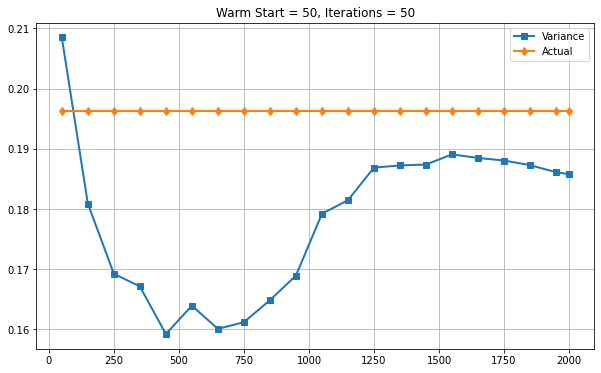

In [171]:
plt.figure(figsize=(10,6))
x = np.linspace(50, 1950, 20)
x = np.append(x, 2000)
plt.plot(x, t.detach().numpy(), label='Variance', linewidth=2, marker='s')
plt.plot(x, [actual.item()]*x.shape[0], label='Actual', linewidth=2, marker='d')
plt.legend()
plt.grid()
plt.title('Warm Start = 50, Iterations = 50')
plt.show()

AttributeError: ignored

In [ ]:

new_y0 =  blackbox(.float())
new_y1 = blackbox(q1.float())
new_y0.mean()-new_y1.mean()
# warm_start_y0.float().mean() - warm_start_y1.float().mean()

tensor(0.1831, device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
X = flagged_X0
X =flagged_X1
x_new = flagged_x_new
A = x_new@(X.t())
K =  X@(X.t())
##k(x_new,x_new)           ## torch.sum(x_new.X[i,:])
torch.sum(x_new * x_new) +0.1 - A@torch.inverse(K+0.1*torch.eye(K.shape[0]).to(device))@A.t() 

tensor([[80.3355]], device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
torch.sum(x_new * x_new) 
x_new@x_new.t()
K

tensor([[8.2852, 4.3340, 4.4040,  ..., 4.0772, 3.3389, 6.1568],
        [4.3340, 8.5060, 4.5015,  ..., 5.0772, 3.4083, 6.1812],
        [4.4040, 4.5015, 8.6500,  ..., 4.0732, 2.5113, 5.2155],
        ...,
        [4.0772, 5.0772, 4.0732,  ..., 8.0376, 3.0772, 5.0455],
        [3.3389, 3.4083, 2.5113,  ..., 3.0772, 8.4153, 3.1837],
        [6.1568, 6.1812, 5.2155,  ..., 5.0455, 3.1837, 8.0868]],
       device='cuda:0')

In [ ]:
var_term

tensor([[3.9061e+16]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
for x in model0.parameters():
    print(x.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [ ]:
model0(torch.zeros((1,102)).to(device))

RuntimeError: You must train on the training inputs!

In [ ]:
lambda_reg = 1.0
candidates = []
neg_queried = warm_start_x0.clone()
neg_labels = warm_start_y0.clone().unsqueeze(1)

for epoch_outer in tqdm(range(1, 4001)):
    x0_random = torch.normal(0.,1.,size=(1,102), dtype=torch.float32, requires_grad=True)
    optimizer0 = torch.optim.AdamW((x0_random,), lr=1.0)
    best_loss = 10e5
    count = 0
    losses = []
    for epoch in range(1,100):
        optimizer0.zero_grad()
        x0_samples = utils.postprocess(
            vae0.sample(x0_random.to(device), 100, device, 
                        **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False}).squeeze(1),
            'adult_income'
        )
        obj0 = likelihood0(model0(x0_samples.to(device))).variance.sum(axis=0).mean() - lambda_reg * ((x0_random.to(device) - x0_samples)**2).mean()
#         print(obj0.shape)
        loss = -obj0
        loss.backward()
        optimizer0.step()
        if loss < best_loss:
            best_loss = loss
            count = 0
            losses.append(loss)
        else:
            count += 1
        if count  == 5:
            break
    x0_query = dfx_0.iloc[np.argmin(np.linalg.norm(np.array(dfx_0) - x0_random.detach().clone().numpy()))]
    candidates.append(torch.Tensor([x0_query]).float().to(device))
    
    if epoch_outer % 100 == 0:
        new_vals = torch.concatenate(candidates)
        new_queries,_, _ = vae0(new_vals.to(device), **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False})
        new_labels = blackbox(new_queries)
        neg_queried = torch.concatenate([neg_queried, new_queries])
        neg_labels = torch.concatenate([neg_labels, (0.5*(torch.sign(new_labels - 0.5) + 1.0)).long().detach().clone()])
        print(neg_labels.shape, neg_labels.dtype)
        print(neg_queried.shape, neg_queried.dtype)
        model0, likelihood0 = train(neg_queried.detach().clone(),neg_labels.flatten())
        model0.eval()
        likelihood0.eval()
        candidates = []

  0%|          | 0/4000 [00:00<?, ?it/s]

torch.Size([1100, 1]) torch.int64
torch.Size([1100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1200, 1]) torch.int64
torch.Size([1200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1300, 1]) torch.int64
torch.Size([1300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1400, 1]) torch.int64
torch.Size([1400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1500, 1]) torch.int64
torch.Size([1500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1600, 1]) torch.int64
torch.Size([1600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1700, 1]) torch.int64
torch.Size([1700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1800, 1]) torch.int64
torch.Size([1800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1900, 1]) torch.int64
torch.Size([1900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2000, 1]) torch.int64
torch.Size([2000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2100, 1]) torch.int64
torch.Size([2100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2200, 1]) torch.int64
torch.Size([2200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2300, 1]) torch.int64
torch.Size([2300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2400, 1]) torch.int64
torch.Size([2400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2500, 1]) torch.int64
torch.Size([2500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2600, 1]) torch.int64
torch.Size([2600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2700, 1]) torch.int64
torch.Size([2700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2800, 1]) torch.int64
torch.Size([2800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2900, 1]) torch.int64
torch.Size([2900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3000, 1]) torch.int64
torch.Size([3000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3100, 1]) torch.int64
torch.Size([3100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3200, 1]) torch.int64
torch.Size([3200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3300, 1]) torch.int64
torch.Size([3300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3400, 1]) torch.int64
torch.Size([3400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3500, 1]) torch.int64
torch.Size([3500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3600, 1]) torch.int64
torch.Size([3600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3700, 1]) torch.int64
torch.Size([3700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3800, 1]) torch.int64
torch.Size([3800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3900, 1]) torch.int64
torch.Size([3900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4000, 1]) torch.int64
torch.Size([4000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4100, 1]) torch.int64
torch.Size([4100, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4200, 1]) torch.int64
torch.Size([4200, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4300, 1]) torch.int64
torch.Size([4300, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4400, 1]) torch.int64
torch.Size([4400, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4500, 1]) torch.int64
torch.Size([4500, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4600, 1]) torch.int64
torch.Size([4600, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4700, 1]) torch.int64
torch.Size([4700, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4800, 1]) torch.int64
torch.Size([4800, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([4900, 1]) torch.int64
torch.Size([4900, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([5000, 1]) torch.int64
torch.Size([5000, 102]) torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
candidates = []
pos_queried = warm_start_x1.clone()
pos_labels = warm_start_y1.clone().unsqueeze(1)
print(pos_labels.shape, pos_labels.dtype)
print(pos_queried.shape, pos_queried.dtype)

for epoch_outer in tqdm(range(1, 4001)):
    x1_random = torch.normal(0.,1.,size=(1,102), dtype=torch.float32, requires_grad=True)
    optimizer1 = torch.optim.AdamW((x1_random,), lr=1.0)
    best_loss = 10e5
    count = 0
    losses = []
    for epoch in range(1,100):
        optimizer1.zero_grad()
        x1_samples = utils.postprocess(
            vae1.sample(x1_random.to(device), 100, device, 
                        **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False}).squeeze(1),
            'adult_income'
        )
        obj1 = likelihood1(model1(x1_samples.to(device))).variance.sum(axis=0).mean() - lambda_reg * ((x1_random.to(device) - x1_samples)**2).mean()
#         print(obj0.shape)
        loss = -obj1
        loss.backward()
        optimizer1.step()
        if loss < best_loss:
            best_loss = loss
            count = 0
            losses.append(loss)
        else:
            count += 1
        if count  == 5:
            break
    x1_query = dfx_1.iloc[np.argmin(np.linalg.norm(np.array(dfx_1) - x1_random.detach().clone().numpy()))]
    candidates.append(torch.Tensor([x1_query]).float().to(device))
    
    if epoch_outer % 100 == 0:
        new_vals = torch.concatenate(candidates)
        new_queries,_ , _ = vae1(new_vals.to(device), **{'tau': 1.0, 'tau_min': 0.1, 'anneal_rate': 3e-5, 'steps': 0, 'hard': False})
        new_labels = blackbox(new_queries)
        pos_queried = torch.concatenate([pos_queried, new_queries])
        pos_labels = torch.concatenate([pos_labels, (0.5*(torch.sign(new_labels - 0.5) + 1.0)).long().detach().clone()])
        model1, likelihood1 = train(pos_queried.detach().clone(),pos_labels.flatten())
        model1.eval()
        likelihood1.eval()
        candidates = []

torch.Size([1000, 1]) torch.int64
torch.Size([1000, 102]) torch.float32


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
pos_labels.shape

torch.Size([5000, 1])

In [ ]:
new_labels.shape

torch.Size([100, 1])

In [ ]:
# parity in data
np.abs(dfy[dfx[dfx.gender == 0].index].mean() - dfy[dfx[dfx.gender == 1].index].mean())

0.19911019753072282

In [ ]:
bb_input0 = torch.from_numpy(dfx_0.values).float().to(device)
bb_input1 = torch.from_numpy(dfx_1.values).float().to(device)

In [ ]:
y0 = blackbox(bb_input0)
y1 = blackbox(bb_input1)

In [ ]:
y0_ = torch.round(y0)
y1_ = torch.round(y1)

In [ ]:
y0_.sum()

tensor(7659., device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
torch.abs(y0_.mean() - y1_.mean())

tensor(0.1869, device='cuda:0', grad_fn=<AbsBackward0>)

In [ ]:
dp_value = torch.abs(pos_labels.squeeze().float().mean() - neg_labels.squeeze().float().mean())
dp_value

tensor(0.0406, device='cuda:0')

In [ ]:
pos_labels.float().mean()

tensor(0.0196, device='cuda:0')

In [ ]:
neg_labels.float().mean()

tensor(0.0602, device='cuda:0')

In [ ]:
torch.save(dp_value, 'results/adult_income/dp_value_vanilla_vae_reg.pt')